**Resources used to get CNN working:**

CNN notebook architecture reference video:
https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=13

Wayne's previous CNN Project
https://colab.research.google.com/drive/103d2kBaVF2L0jEnkgZKcJzgm1jZaqlbA?usp=sharing


In [159]:
## imports ##

import torch                                  ## pytorch package
import torch.nn as nn                         ## pytorch neural network package
import torch.optim as optim
import torchvision                            ## see more at: https://pytorch.org/vision/stable/index.html
import torchvision.transforms as transforms   ## image transformation package
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(linewidth=120)

In [160]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [161]:
## device config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [201]:
## hyper-parameters

# input_size = None    # this will depend on each image size
# hidden_size = None   # not sure what this is
num_classes = 3   # number of classifications (i.e. number of different accents)
num_epochs = 10    # number of iterations of the training set
batch_size = 8    # the number of samples that will be propagated through the network each time
learning_rate = 0.001 # steps towards the min loss 

In [163]:
## data preparation ##
'''
    at this point, the data has been cleaned (i.e. reduced whitenoise and normalized) 
    and converted into melspectra stored in png
    Each png has size = 432x288
    Instead of spliting recordings into tens of classes, we decided to only go with three classes: English, Spanish and Arabic

    # two key modules when loading data: 
    torch.utils.data.Dataset	An abstract class for representing a dataset
    torch.utils.data.DataLoader	Wraps a dataset and provides access to the underlying data
'''

train_path = 'accent_melspectra/train'
test_path = 'accent_melspectra/test'

In [164]:
## calculating mean and std for transformation ##
## TODO: learn how to calculate the mean
## tutorial here: https://www.youtube.com/watch?v=z3kB3ISIPAg&t=343s
## and here: https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c

# resize the input images and convert them to tensor
training_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform=training_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

def get_mean_and_std(loader):

    mean = 0.
    std = 0.
    total_image_count = 0

    for image, _ in loader:
        image_count_in_batch = image.size(0)
        # print(image.shape)
        image = image.view(image_count_in_batch, image.size(1), -1)
        # print("after",image.shape)
        mean += image.mean(2).sum(0)
        std += image.std(2).sum(0)
        total_image_count += image_count_in_batch
    
    mean /= total_image_count
    std /= total_image_count

    return mean, std

get_mean_and_std(train_loader)

(tensor([0.5420, 0.4600, 0.5431]), tensor([0.4353, 0.4592, 0.4039]))

In [165]:
mean = [0.5420, 0.4600, 0.5431]
std = [0.4353, 0.4592, 0.4039]

train_transform = transforms.Compose([
    transforms.Resize((256,256)),    # resize factors are arbitrarily chosen
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),    # resize factors are arbitrarily chosen
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## currently the tensor that represents the batch should look like:
# tensor([batch_size, 3, 256, 256])
# tensor([batch_size, num_colors, height, width])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1])

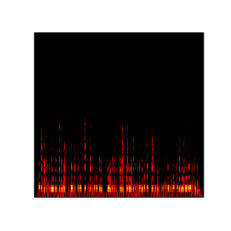

In [166]:
## see if images are loaded correctly

images, labels = next(iter(train_loader))
imshow(images[0], normalize=False)
labels

In [167]:
class NeuralNet(nn.Module): ## the class must extend from nn.module
  def __init__(self):
    super(NeuralNet,self).__init__()

    ## layer parameters ##
    """
      NOTE:
        each layer is extended from pytorch's neural network module class
        two items are encapsulated in each layer: a forward function definition and a weight tensor
        weight_values in the weight_tensor are updated throughout the training process

        In CNN, we typically work with 2 kinds of layers:
          - convolutional layer
          - linear (full-connected) layer
          - when switching from convolutional layer to linear layer,
            we need to flatten our input

        hyper-parameters in these layers:
          - kernel_size
          - out_channels (number of filters)
          - out_features (in linear layers)
        
        data-dependent parameters:
          - in_channels in the first layer(number of color channels)
          - out_features in the last channel = num_classes
          - all in_channels and in_features should correspond to
            the number of out_channel of the previous layer
    """
    
    #self.conv1 = nn.Conv2d(in_channels=number of colors incoming, out_channels=num of kernels, kernel_size=width of kernel)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=5)

    ## before passing onto linear layers, output must be flattened

    self.fc1 = nn.Linear(in_features=18*12*12, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.fc3 = nn.Linear(in_features=60, out_features=30)
    self.out = nn.Linear(in_features=30, out_features=num_classes)

  
  def forward(self,t):
    '''
      the process of tranforming input data to a list of probabilities
    '''
    t = self.conv1(t)
    t = nn.functional.relu(t)
    t = nn.functional.max_pool2d(t, kernel_size=2, stride=2)

    t = self.conv2(t)
    t = nn.functional.relu(t)
    t = nn.functional.max_pool2d(t, kernel_size=2, stride=2)

    t = self.conv3(t)
    t = nn.functional.relu(t)
    t = nn.functional.max_pool2d(t, kernel_size=2, stride=5)

    ## must reshape before passing into linear layer ##
    t = t.reshape(-1, 18*12*12)

    t = self.fc1(t)
    t = nn.functional.relu(t)

    t = self.fc2(t)
    t = nn.functional.relu(t)

    t = self.fc3(t)
    t = nn.functional.relu(t)

    # output tensor (should have 3 elements)
    t = self.out(t)
    #t = F.softmax(t,dim=1)  ## we will be using this in cross entropy function

    return t

In [168]:
# torch.set_grad_enabled(True)

In [169]:
## verifying the network works as expected before training
network = NeuralNet()
sample = next(iter(train_dataset))
image, label = sample  ##
# image.shape
# print(label)
# test_sample = image.unsqueeze(0)

pred = network(test_sample) # we do this because we must pass batches of images into network instead of singles images
pred


tensor([[-0.1251,  0.0044,  0.0245]], grad_fn=<AddmmBackward0>)

In [170]:
## still verifying...

sample = next(iter(train_loader))
images, labels = sample  ## images correspond to the batches now
preds = network(images) # we do this because we must pass batches of images into network instead of singles images
print(preds) # this genreates the prediction for one batch of images

## we use the argmax function the find the index of image with largest likelihood

max_index_pos_in_pred = preds.argmax(dim=1)
print(max_index_pos_in_pred)

tensor([[-0.1270,  0.0052,  0.0229],
        [-0.1261,  0.0059,  0.0245],
        [-0.1265,  0.0063,  0.0245],
        [-0.1267,  0.0057,  0.0238],
        [-0.1273,  0.0060,  0.0238],
        [-0.1259,  0.0058,  0.0242],
        [-0.1272,  0.0050,  0.0238],
        [-0.1265,  0.0053,  0.0244],
        [-0.1272,  0.0058,  0.0240],
        [-0.1266,  0.0049,  0.0227],
        [-0.1279,  0.0053,  0.0230],
        [-0.1269,  0.0049,  0.0230],
        [-0.1262,  0.0055,  0.0247],
        [-0.1266,  0.0057,  0.0240],
        [-0.1265,  0.0059,  0.0253],
        [-0.1264,  0.0064,  0.0236]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [171]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [204]:
## The actual training ##
## useful resource: https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers
network = NeuralNet() # create a network instance
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

def start_training():

    history = []

    for epoch in range(num_epochs):

        total_loss = 0
        total_correct = 0

        progress_counter = 0
        for batch in train_loader:
            images, labels = batch

            optimizer.zero_grad()

            preds = network(images)
            loss = nn.functional.cross_entropy(preds, labels) ## calculate loss
            loss.backward()
            
            optimizer.step()

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)
            progress_counter += 1
            print("current batch progress: ", progress_counter / len(train_loader))
        
        print("Epoch: ", epoch, "total correct: ", total_correct, "total loss: ", total_loss)
        history.append(total_loss)
    
    return total_correct, history

# start_training()


current batch progress:  0.023809523809523808
current batch progress:  0.047619047619047616
current batch progress:  0.07142857142857142
current batch progress:  0.09523809523809523
current batch progress:  0.11904761904761904
current batch progress:  0.14285714285714285
current batch progress:  0.16666666666666666
current batch progress:  0.19047619047619047
current batch progress:  0.21428571428571427
current batch progress:  0.23809523809523808
current batch progress:  0.2619047619047619
current batch progress:  0.2857142857142857
current batch progress:  0.30952380952380953
current batch progress:  0.3333333333333333
current batch progress:  0.35714285714285715
current batch progress:  0.38095238095238093
current batch progress:  0.40476190476190477
current batch progress:  0.42857142857142855
current batch progress:  0.4523809523809524
current batch progress:  0.47619047619047616
current batch progress:  0.5
current batch progress:  0.5238095238095238
current batch progress:  0.54

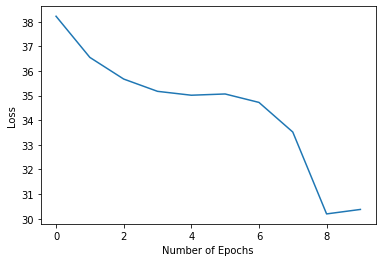

In [200]:
### Evaluating the training set ###
total_correct, history = start_training()
correct_percent = total_correct / len(train_dataset)
print("training correct percentage = ", correct_percent)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.plot(history)
print(history)

In [205]:
## The actual testing ##

def start_testing():
    for epoch in range(num_epochs):
        total_correct = 0
        total_loss = 0
        progress_counter = 0

        for batch in test_loader:
            with torch.no_grad():
                network.eval()
                images, labels = batch
                preds = network(images)
                loss = nn.functional.cross_entropy(preds, labels) ## calculate loss
                
                total_loss += loss.item()
                total_correct += get_num_correct(preds, labels)
                progress_counter += 1
                print("current batch progress: ", progress_counter / len(train_loader))
        
        print("Epoch: ", epoch, "total correct: ", total_correct, "total loss: ", total_loss)
    
    return total_correct


In [206]:
### Evaluating the training set
total_correct = start_testing()
correct_percent = total_correct / len(test_dataset)
print("testing correct percentage = ", correct_percent)

current batch progress:  0.023809523809523808
current batch progress:  0.047619047619047616
current batch progress:  0.07142857142857142
current batch progress:  0.09523809523809523
current batch progress:  0.11904761904761904
current batch progress:  0.14285714285714285
current batch progress:  0.16666666666666666
current batch progress:  0.19047619047619047
current batch progress:  0.21428571428571427
current batch progress:  0.23809523809523808
current batch progress:  0.2619047619047619
Epoch:  0 total correct:  117 total loss:  11.579944014549255
current batch progress:  0.023809523809523808
current batch progress:  0.047619047619047616
current batch progress:  0.07142857142857142
current batch progress:  0.09523809523809523
current batch progress:  0.11904761904761904
current batch progress:  0.14285714285714285
current batch progress:  0.16666666666666666
current batch progress:  0.19047619047619047
current batch progress:  0.21428571428571427
current batch progress:  0.23809523